# Scaling the 2d Acoustic Wave Equation

## Unscaled version

2d Acoustic Wave Equation: $\frac{\partial^2 p}{\partial t^2} = c^2 \nabla^2 p + s(x, z, t)$

Where $ p \equiv p(x, z, t) $ and $ s(x, z, t) $ is a source term

In [102]:
# import dependencies 
import devito as dv
import numpy as np
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import plot_image

# Initial grid: 2km x 2km, with spacing 100m
extent = (2000., 2000.)
shape = (200, 200)
x = dv.SpaceDimension(name='x', spacing=dv.Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = dv.SpaceDimension(name='z', spacing=dv.Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# calculating timestep with CFL condition, max V_p=6000, and dx=100
# played around with tn to get different output images - wave hits the edge of the grid around tn=400
t0, tn = 0., 300.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# creating pressure field
p = dv.TimeFunction(name='p', grid=grid, space_order=2, time_order=2)

# setting up velocity field with a layered model
vp = dv.Function(name='vp', grid=grid)
vp.data[:, :100] = 2.0  # layer 1: 2km/s
vp.data[:, 100:] = 3.5  # layer 2: 3.5km/s

# injecting the source term to the pressure field, multiply expr by something to increase size
src_p = src.inject(field=p.forward, expr=src)

# defining pde and creating stencil
pde = p.dt2 - vp**2*p.laplace
stencil = dv.Eq(p.forward, dv.solve(pde, p.forward))

# set up operator
op = dv.Operator([stencil] + src_p)

# call operator to propagate source
op(time=src.time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.004668999999999975, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

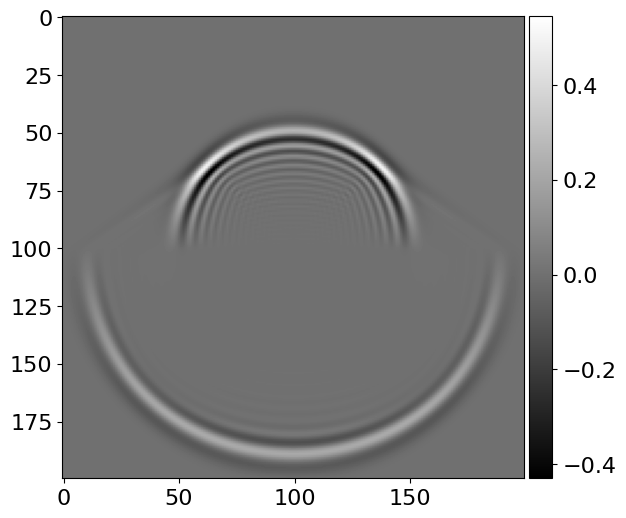

In [103]:
plot_image(p.data[0])